In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

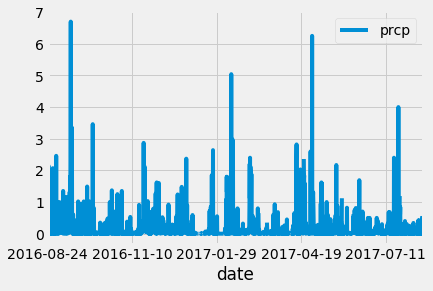

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")
late_yr = int(dt.datetime.strftime(latest_date, "%Y"))
late_mo = int(dt.datetime.strftime(latest_date, "%m"))
late_day = int(dt.datetime.strftime(latest_date, "%d"))
                                   

# Calculate the date 1 year ago from the last data point in the database
prev_year = dt.date(late_yr,late_mo,late_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>prev_year).\
          order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)
precip_df = precip_df.set_index('date')

# Sort the dataframe by date
precip_df = precip_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
station_ct = session.query(Station).count()
print(f"The number of stations is {station_ct}")

The number of stations is 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_stations = (session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).order_by(func.count(Measurement.station).\
                                                          desc()).all())

# List the stations and the counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = active_stations[0] [0]

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs).\
    filter(Measurement.station == station_id))
stats_list = list(stats)
print(stats_list)

[(53.0, 87.0, 71.66378066378067)]


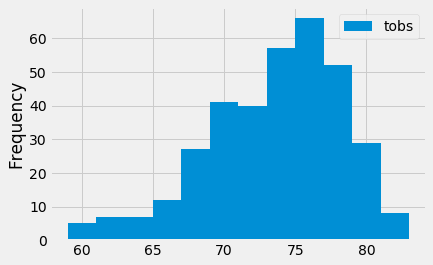

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = (session.query(Measurement.tobs,Measurement.date).filter(Measurement.date>prev_year).\
                     filter(Measurement.station == station_id)\
                    .order_by(Measurement.date).all())
temp_df = pd.DataFrame(temp)
temp_df = temp_df.set_index('date')

temp_df.plot(kind='hist', bins=12)
plt.show()


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = "2020-04-19 to \n 2020-05-02"
trip_start = "2017-04-19"
trip_end = "2017-05-02"

trip_temps = calc_temps(trip_start, trip_end)
print(trip_temps)

[(58.0, 73.2840909090909, 83.0)]


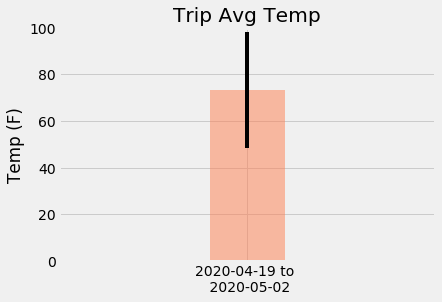

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = trip_temps[0] [0]
tavg = trip_temps[0] [1]
tmax = trip_temps[0] [2]

plt.bar(trip, tavg, yerr=(tmax-tmin), alpha=0.5, color="coral")
plt.ylim (0,100)
plt.xlim(-2, 2)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                              func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).\
                             filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).\
                             group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
trip_rain_df = pd.DataFrame(trip_rainfall, columns = ["Station", "Name", "Latitude", "Longitude", "Elevation", "Total Precipitation"])
trip_rain_df



,Station,Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,10.35
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,6.90
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.98
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.90
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,4.16
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.92
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
from datetime import timedelta, date
# Set the start and end date of the trip
start_date = date(2020, 4, 19)
end_date = date(2020, 5, 2)


# Use the start and end date to create a range of dates
daterange = pd.date_range(start_date, end_date)
daterange
    
# Stip off the year and save a list of %m-%d strings
date_list = daterange.strftime("%m-%d")
date_list

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_norms = [daily_normals(date) for date in date_list]
trip_norms

[[(65.0, 72.42105263157895, 83.0)],
 [(64.0, 72.73684210526316, 80.0)],
 [(66.0, 72.32142857142857, 78.0)],
 [(65.0, 72.92727272727272, 84.0)],
 [(65.0, 73.01818181818182, 79.0)],
 [(67.0, 73.3103448275862, 80.0)],
 [(66.0, 73.96551724137932, 83.0)],
 [(66.0, 74.01724137931035, 81.0)],
 [(65.0, 72.87272727272727, 81.0)],
 [(63.0, 73.46428571428571, 79.0)],
 [(66.0, 73.30357142857143, 81.0)],
 [(58.0, 71.5576923076923, 78.0)],
 [(65.0, 72.75925925925925, 79.0)],
 [(65.0, 73.05084745762711, 79.0)]]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_norms = [np.array(norm [0]) for norm in trip_norms]
trip_norms_df = pd.DataFrame(trip_norms)

trip_norms_df["Date"] = date_list

trip_norms_df = trip_norms_df.set_index("Date")
trip_norms_df = trip_norms_df.rename(columns={0: "tmin", 1: "tavg", 2: "tmax"})


trip_norms_df


,tmin,tavg,tmax
Date,,,
04-19,65.0,72.421053,83.0
04-20,64.0,72.736842,80.0
04-21,66.0,72.321429,78.0
04-22,65.0,72.927273,84.0
04-23,65.0,73.018182,79.0
04-24,67.0,73.310345,80.0
04-25,66.0,73.965517,83.0
04-26,66.0,74.017241,81.0
04-27,65.0,72.872727,81.0


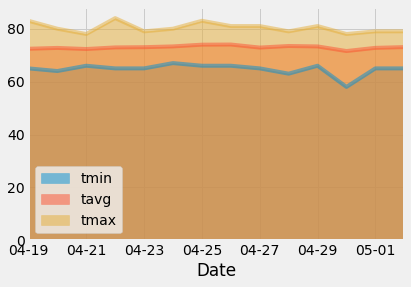

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
trip_norms_df.plot.area(stacked=False, alpha=0.5)
